In [ ]:
!nvidia-smi

Wed Feb 24 01:37:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%cd /content

/content


In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-02-24 21:54:38--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  19.6MB/s    in 19s     

2021-02-24 21:54:57 (12.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
!unzip -q tiny-imagenet-200.zip

In [4]:
!git clone https://github.com/ShivamShrirao/tiny-imagenet-test

Cloning into 'tiny-imagenet-test'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 17 (delta 4), reused 14 (delta 1), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [1]:
%cd tiny-imagenet-test

/content/tiny-imagenet-test


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import glob
import os
import csv
from tqdm.notebook import tqdm
from time import time
import random
%matplotlib inline

In [4]:
# tf.keras.backend.set_image_data_format('channels_first')

In [5]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

In [6]:
img_height, img_width = 64, 64
BATCH_SIZE = 128

In [7]:
TRAIN_PATH = "../tiny-imagenet-200/train/"
TEST_PATH = "../tiny-imagenet-200/test/"
VAL_PATH = "../tiny-imagenet-200/val/"

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
class_names = np.array(sorted([fp.split('/')[-1] for fp in glob.glob(TRAIN_PATH+"*")]))

In [10]:
val_labels = {}
with open(VAL_PATH+"val_annotations.txt") as fIn:
    reader = csv.reader(fIn, delimiter='\t')
    for row in reader:
        val_labels[row[0]] = row[1]

In [11]:
def get_train_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-3] == class_names
    return tf.argmax(one_hot)

def get_val_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    name = parts[-1].numpy().decode()
    one_hot = val_labels[name] == class_names
    return tf.argmax(one_hot)

def decode_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = img/255.0
    return img

def process_train_path(file_path):
    label = get_train_label(file_path)
    img = decode_img(file_path)
    return img, label

get_val_label_wrapper = lambda x: tf.py_function(get_val_label, [x], tf.int64)

def process_val_path(file_path):
    label = get_val_label_wrapper(file_path)
    img = decode_img(file_path)
    return img, label

In [54]:
train_list_ds = tf.data.Dataset.list_files(TRAIN_PATH+"*/images/*", shuffle=True
            ).map(process_train_path, num_parallel_calls=AUTOTUNE
            ).cache()

In [55]:
val_list_ds = tf.data.Dataset.list_files(VAL_PATH+"images/*"
            ).map(process_val_path, num_parallel_calls=AUTOTUNE
            ).cache()

In [14]:
mean = []
std = []
for a,b in train_list_ds.take(1024):
    mean.append(a.numpy())
    std.append(a.numpy())
mean = np.asarray(mean).mean(axis=(0,1,2)).reshape(1,3,1,1)
std = np.asarray(std).std(axis=(0,1,2)).reshape(1,3,1,1)

In [15]:
mean.ravel(), std.ravel()

(array([0.47657734, 0.45386508, 0.3950202 ], dtype=float32),
 array([0.27600715, 0.26707038, 0.2805239 ], dtype=float32))

In [16]:
mean = tf.convert_to_tensor(mean)
std = tf.convert_to_tensor(std)
def channel_first_and_normalize(img, lbl, mean=mean, std=std):    # over batches
    img = tf.transpose(img, perm=[0,3,1,2])
    img = img - mean
    img = img / std
    return img, lbl

In [68]:
def augment(img_lbl, seed):         # over individual image
    img, lbl = img_lbl
    # Make a new seed
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random Contrast
    img = tf.image.stateless_random_contrast(img, 0.5, 1, seed)
    # Hue
    img = tf.image.stateless_random_hue(img, 0.05, new_seed)
    # Saturation
    img = tf.image.stateless_random_saturation(img, 0.4, 2, seed)
    # Random brightness
    img = tf.image.stateless_random_brightness(img, 0.2, new_seed)
    img = tf.clip_by_value(img, 0, 1)
    return img, lbl

In [69]:
rng = tf.random.Generator.from_seed(123, alg='philox')
# A wrapper function for updating seeds
def augment_wrapper(x, y):
    seed = rng.make_seeds(2)[0]
    img, lbl = augment((x, y), seed)
    return img, lbl

In [70]:
data_augmentation = tf.keras.Sequential([                       # over batches
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomHeight(0.3),
    layers.experimental.preprocessing.RandomWidth(0.3),
    layers.experimental.preprocessing.RandomTranslation(0.3,0.3),
    layers.experimental.preprocessing.RandomRotation(0.12),     # 0.12 * 2pi = 43.2 deg
    layers.experimental.preprocessing.Resizing(img_height, img_width)
])

In [71]:
# PIL.Image.fromarray((a*255).numpy().astype(np.uint8))
# c,_ = augment((a,None), rng.make_seeds(2)[0])
# c = data_augmentation((c[None,...]), training=True)[0]
# PIL.Image.fromarray((c*255).numpy().astype(np.uint8))

In [72]:
train_ds = (
    train_list_ds
    .map(augment_wrapper, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    .map(channel_first_and_normalize, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [73]:
val_ds = (
    val_list_ds
    .batch(BATCH_SIZE)
    .map(channel_first_and_normalize, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [74]:
a, b = next(iter(train_ds))
a.shape

TensorShape([128, 3, 64, 64])

In [81]:
idx = np.random.randint(0,128)
x = a.numpy()[idx]
z = (x-x.min())/(x.max()-x.min())
z = z.transpose(1,2,0)
class_names[b[idx]]

'n03649909'

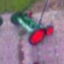

In [82]:
PIL.Image.fromarray((z*255).astype(np.uint8))

In [ ]:
config_defaults = {
    'activation'            : 'leaky_relu',
    'dp_rate'               : 0.2,
    'batch_size'            : BATCH_SIZE,
    'norm'                  : 'bn',
    'self_attn'             : True,
    'frac_dk'               : 0.5,
    'frac_dv'               : 0.25,
    'pos_emb'               : True,
    'optimizer'             : 'adamw',
    'min_lr'                : 2e-6,
    'max_lr'                : 8e-4,
    'weight_decay'          : 2e-5,
    'clr_step_size'         : 8,
    'loss_function'         : 'cce',
}

In [ ]:
class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [ ]:
CONFIG = AttributeDict(config_defaults)

In [ ]:
import model

In [ ]:
model.CONFIG = CONFIG

In [ ]:
inp = layers.Input(shape=(3,img_height, img_width))

In [ ]:
x = model.conv_norm(inp, 8, kernel_size=5, strides=1, activation=CONFIG.activation)
x = model.conv_norm(x, 32, kernel_size=3, strides=2, activation=CONFIG.activation,
                    do_norm_act=False)

In [ ]:
x = model.down_stack(x, fltrs=[ 8,16,16], self_attn=False, dp_rate=CONFIG.dp_rate)   # (64, 16, 16)
x = model.down_stack(x, fltrs=[16,32,32], self_attn=[False, True, True], dp_rate=CONFIG.dp_rate)   # (128, 8, 8)
x = model.down_stack(x, fltrs=[32,64,64], self_attn=True, dp_rate=CONFIG.dp_rate)   # (256, 4, 4)

In [ ]:
x = model.conv_norm(x, 512, kernel_size=3, strides=1, activation=CONFIG.activation)
x = layers.GlobalAveragePooling2D(data_format="channels_first")(x)
if CONFIG.dp_rate:
    x = layers.Dropout(CONFIG.dp_rate)(x)
x = layers.Dense(CLASSES)(x)
x = layers.Softmax(axis=1)(x)

In [ ]:
m = tf.keras.Model(inputs=inp, outputs=x)
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 64, 64)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 64, 64)    608         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8, 64, 64)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 8, 64, 64)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
ret = tf.keras.utils.plot_model(m, to_file='model.svg', show_shapes=True, dpi=None)

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
# wandb.login()

In [ ]:
# run = wandb.init(project="tiny-imagenet-test", entity="shivamshrirao", config=config_defaults)
# CONFIG = wandb.config